In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split


In [27]:
df = pd.DataFrame()

In [51]:
# simulating time
times = pd.date_range("00:00", "23:45", freq="15min")
n = len(times)

# base temp (27c) sim 
temperature = 27 + 0.7 * np.sin(np.linspace(0, 2*np.pi, n)) + np.random.normal(0, 0.2, n)

# cooling event caused by break down
cool_length = 8  # 2 hours
cool_start = np.random.randint(10, n - cool_length - 10) 
cool_end = cool_start + cool_length
temperature[cool_start:cool_end] -= 2.5  

# Artemia count with growth and some noise
base_count = 160
growth = np.linspace(0, 20, n)
noise = np.random.normal(0, 1, n)

# count drop triggered at the end of the cooling event
drop = np.zeros(n)
drop_trigger = cool_end
drop[drop_trigger:] = -45  # sudden die off

artemia_count = base_count + growth + noise + drop
artemia_count = np.maximum(artemia_count, 0).astype(int)


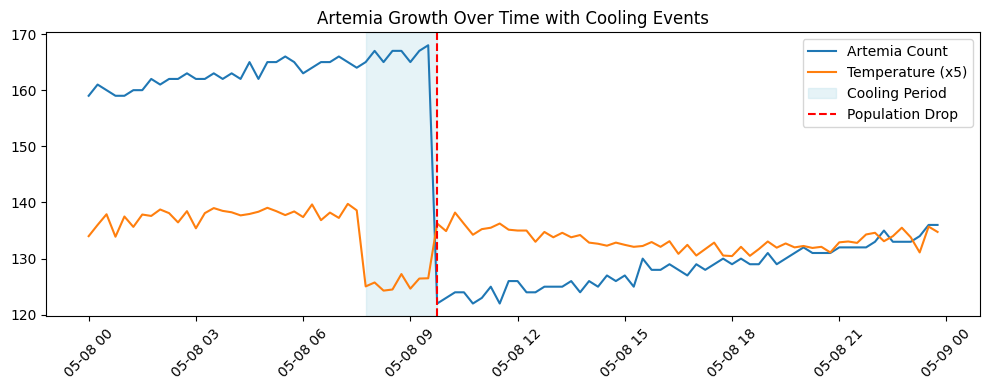

In [52]:

df = pd.DataFrame({'time': times,'temperature': np.round(temperature, 2),'artemia_count': artemia_count})


plt.figure(figsize=(10, 4))
plt.plot(df['time'], df['artemia_count'], label='Artemia Count')
plt.plot(df['time'], df['temperature'] * 5, label='Temperature (x5)')  # x5 to scale for plot
plt.axvspan(df['time'][cool_start], df['time'][cool_end], color='lightblue', alpha=0.3, label='Cooling Period')
plt.axvline(df['time'][drop_trigger], color='red', linestyle='--', label='Population Drop')
plt.legend()
plt.title("Artemia Growth Over Time with Cooling Events")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [46]:
df

,time,temperature,artemia_count
0,2025-05-08 00:00:00,27.06,164
1,2025-05-08 00:15:00,26.86,157
2,2025-05-08 00:30:00,27.04,168
3,2025-05-08 00:45:00,27.15,166
4,2025-05-08 01:00:00,27.63,159
...,...,...,...
91,2025-05-08 22:45:00,27.24,131
92,2025-05-08 23:00:00,27.01,137
93,2025-05-08 23:15:00,27.26,135
94,2025-05-08 23:30:00,26.68,132


In [61]:
# create the sliding window dw

for i in range(1,15):
    df[f'count_t-{i}'] = df['artemia_count'].shift(i)

df = df.dropna()
df

,time,temperature,artemia_count,count_t-1,count_t-2,count_t-3,count_t-4,count_t-5,count_t-6,count_t-7,count_t-8,count_t-9,count_t-10,count_t-11,count_t-12,count_t-13,count_t-14
28,2025-05-08 07:00:00,27.45,166,165.0,165.0,164.0,163.0,165.0,166.0,165.0,165.0,162.0,165.0,162.0,163.0,162.0,163.0
29,2025-05-08 07:15:00,27.95,165,166.0,165.0,165.0,164.0,163.0,165.0,166.0,165.0,165.0,162.0,165.0,162.0,163.0,162.0
30,2025-05-08 07:30:00,27.72,164,165.0,166.0,165.0,165.0,164.0,163.0,165.0,166.0,165.0,165.0,162.0,165.0,162.0,163.0
31,2025-05-08 07:45:00,25.01,165,164.0,165.0,166.0,165.0,165.0,164.0,163.0,165.0,166.0,165.0,165.0,162.0,165.0,162.0
32,2025-05-08 08:00:00,25.15,167,165.0,164.0,165.0,166.0,165.0,165.0,164.0,163.0,165.0,166.0,165.0,165.0,162.0,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2025-05-08 22:45:00,27.10,133,133.0,135.0,133.0,132.0,132.0,132.0,132.0,131.0,131.0,131.0,132.0,131.0,130.0,129.0
92,2025-05-08 23:00:00,26.76,133,133.0,133.0,135.0,133.0,132.0,132.0,132.0,132.0,131.0,131.0,131.0,132.0,131.0,130.0
93,2025-05-08 23:15:00,26.22,134,133.0,133.0,133.0,135.0,133.0,132.0,132.0,132.0,132.0,131.0,131.0,131.0,132.0,131.0
94,2025-05-08 23:30:00,27.14,136,134.0,133.0,133.0,133.0,135.0,133.0,132.0,132.0,132.0,132.0,131.0,131.0,131.0,132.0


In [62]:
df.columns.values

array(['time', 'temperature', 'artemia_count', 'count_t-1', 'count_t-2',
       'count_t-3', 'count_t-4', 'count_t-5', 'count_t-6', 'count_t-7',
       'count_t-8', 'count_t-9', 'count_t-10', 'count_t-11', 'count_t-12',
       'count_t-13', 'count_t-14'], dtype=object)

In [94]:
features = ['count_t-1', 'count_t-2',
       'count_t-3', 'count_t-4', 'count_t-5', 'count_t-6', 'count_t-7',
       'count_t-8', 'count_t-9', 'count_t-10', 'count_t-11', 'count_t-12',
       'count_t-13', 'count_t-14']

X = df[features]
y = df['artemia_count']


In [95]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# train
model = LinearRegression()
model.fit(X_train, y_train)
predicted_values = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted_values)


In [96]:
for i in range(len(X_test)):
    previous_counts = X_test.iloc[i][['count_t-5', 'count_t-4', 'count_t-3', 'count_t-2', 'count_t-1']].values
    pred = round(predicted_values[i], 1)
    actual = y_test.iloc[i]
    error = round(pred - actual, 1)
    
    print(f"Prev counts: {previous_counts.astype(int)} → Predicted: {pred} | Actual: {actual} | Error: {error}")


Prev counts: [129 130 131 132 131] → Predicted: 131.2 | Actual: 131 | Error: 0.2
Prev counts: [130 131 132 131 131] → Predicted: 131.0 | Actual: 131 | Error: 0.0
Prev counts: [131 132 131 131 131] → Predicted: 130.6 | Actual: 132 | Error: -1.4
Prev counts: [132 131 131 131 132] → Predicted: 131.9 | Actual: 132 | Error: -0.1
Prev counts: [131 131 131 132 132] → Predicted: 131.8 | Actual: 132 | Error: -0.2
Prev counts: [131 131 132 132 132] → Predicted: 131.7 | Actual: 132 | Error: -0.3
Prev counts: [131 132 132 132 132] → Predicted: 131.8 | Actual: 133 | Error: -1.2
Prev counts: [132 132 132 132 133] → Predicted: 132.7 | Actual: 135 | Error: -2.3
Prev counts: [132 132 132 133 135] → Predicted: 134.5 | Actual: 133 | Error: 1.5
Prev counts: [132 132 133 135 133] → Predicted: 132.7 | Actual: 133 | Error: -0.3
Prev counts: [132 133 135 133 133] → Predicted: 132.8 | Actual: 133 | Error: -0.2
Prev counts: [133 135 133 133 133] → Predicted: 132.6 | Actual: 134 | Error: -1.4
Prev counts: [135 1

In [97]:
df.to_csv("artemia_count.csv")

In [99]:
joblib.dump(model, 'regression_model.joblib')

['regression_model.joblib']